### Load required libraries

In [66]:
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import keras
from tensorflow.keras import regularizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Load the data

In [67]:
df = pd.read_csv('./data/creditcard.csv', index_col=0)
print(df.shape)
df.head()

(284807, 30)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,,,,,,,,,,,,,,,,,,,,,
0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### Data check

In [68]:
df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [69]:
df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

In [70]:
df.isnull().values.any()

False

In [71]:
df = df.drop(['Amount'], axis=1)

### Train/test split

In [72]:
frauds = df[df.Class == 1]
#normal = df[df.Class == 0].sample(1000)
normal = df[df.Class == 0]
print("Frauds shape: {}".format(frauds.shape))
print("Normal shape: {}".format(normal.shape))

Frauds shape: (492, 29)
Normal shape: (284315, 29)


In [73]:
data = pd.concat([frauds, normal])
data.shape

(284807, 29)

In [74]:
X_train, X_test = train_test_split(data, test_size=0.3, random_state=42)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

X_test, y_test = X_test.drop(['Class'], axis=1).values, X_test['Class'].values

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape: (199013, 28)
X_test shape: (85443, 28)


### Visualize the data with TSNE and PCA

In [75]:
x1 = df[df.Class == 1]
x2 = df[df.Class == 0].sample(10000)

dfd = x1.append(x2)
x = dfd.drop(['Class'], axis=1)
y = dfd['Class'].values

SEED = 42

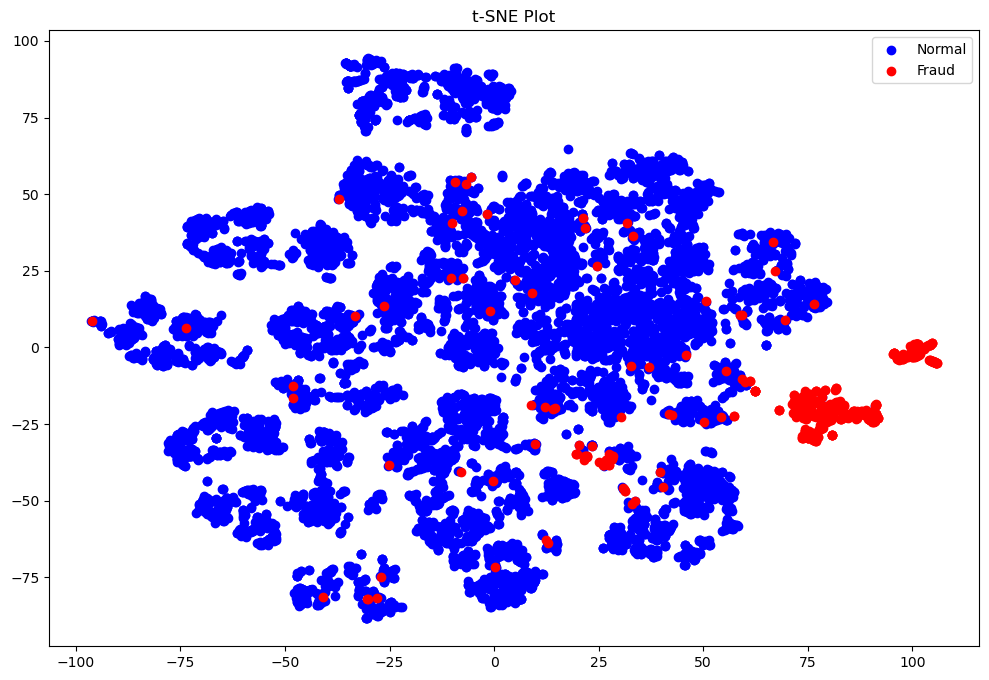

In [76]:
tsne = TSNE(n_components=2, random_state=SEED).fit_transform(x)
plt.figure(figsize=(12,8));
plt.scatter(tsne[np.where(y==0), 0], y=tsne[np.where(y==0), 1], color="blue", label='Normal')
plt.scatter(x=tsne[np.where(y==1), 0], y=tsne[np.where(y==1), 1], color="red", label='Fraud')
plt.title('t-SNE Plot')
plt.legend()
plt.show()

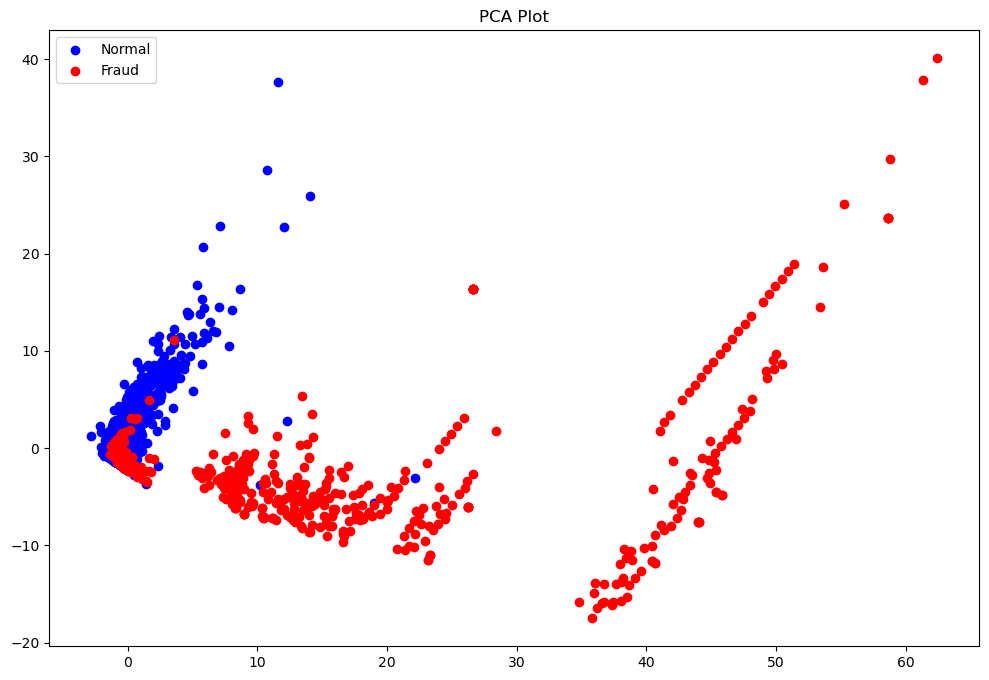

In [77]:
pca = PCA(n_components=2, random_state=SEED).fit_transform(x)
plt.figure(figsize=(12,8));
plt.scatter(pca[np.where(y==0), 0], y=pca[np.where(y==0), 1], color="blue", label='Normal')
plt.scatter(x=pca[np.where(y==1), 0], y=pca[np.where(y==1), 1], color="red", label='Fraud')
plt.title('PCA Plot')
plt.legend()
plt.show()

#### Normalize the data

In [78]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit_transform(X_train);
scaler.transform(X_test);

### AutoEncoder Model

In [79]:
input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim, ))
encoder = Dense(14, activation="elu")(input_layer)
encoder = Dense(7, activation="elu")(encoder)

encoder = Dense(3, activation="elu")(encoder)

decoder = Dense(7, activation="elu")(encoder)
decoder = Dense(14, activation='elu')(decoder)
decoder = Dense(input_dim, activation='elu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [80]:
epochs = 100
batch_size = 32
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="fraudAE.pth", verbose=0, save_best_only=True)

### Training

In [81]:
history = autoencoder.fit(np.array(X_train), np.array(X_train),
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    callbacks=[checkpointer]).history

Epoch 1/100
5581/5598 [============================>.] - ETA: 0s - loss: 0.7482 - accuracy: 0.5126INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 33s 5ms/step - loss: 0.7477 - accuracy: 0.5127 - val_loss: 0.6557 - val_accuracy: 0.5667
Epoch 2/100
5590/5598 [============================>.] - ETA: 0s - loss: 0.6664 - accuracy: 0.5713INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 29s 5ms/step - loss: 0.6666 - accuracy: 0.5713 - val_loss: 0.6245 - val_accuracy: 0.5825
Epoch 3/100
5596/5598 [============================>.] - ETA: 0s - loss: 0.6415 - accuracy: 0.5793INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 28s 5ms/step - loss: 0.6414 - accuracy: 0.5793 - val_loss: 0.6155 - val_accuracy: 0.5880
Epoch 4/100
5591/5598 [============================>.] - ETA: 0s - loss: 0.6317 - accuracy: 0.5852INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 30s 5ms/step - loss: 0.6317 - accuracy: 0.5853 - val_loss: 0.6057 - val_accuracy: 0.6007
Epoch 5/100
5588/5598 [============================>.] - ETA: 0s - loss: 0.6247 - accuracy: 0.5943INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 26s 5ms/step - loss: 0.6247 - accuracy: 0.5942 - val_loss: 0.5986 - val_accuracy: 0.6036
Epoch 6/100
5595/5598 [============================>.] - ETA: 0s - loss: 0.6192 - accuracy: 0.5983INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 28s 5ms/step - loss: 0.6191 - accuracy: 0.5984 - val_loss: 0.5942 - val_accuracy: 0.6021
Epoch 7/100
5584/5598 [============================>.] - ETA: 0s - loss: 0.6140 - accuracy: 0.6000INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 25s 4ms/step - loss: 0.6135 - accuracy: 0.6000 - val_loss: 0.5862 - val_accuracy: 0.6048
Epoch 8/100
5590/5598 [============================>.] - ETA: 0s - loss: 0.6076 - accuracy: 0.6041INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 23s 4ms/step - loss: 0.6075 - accuracy: 0.6041 - val_loss: 0.5818 - val_accuracy: 0.6070
Epoch 9/100
5596/5598 [============================>.] - ETA: 0s - loss: 0.6044 - accuracy: 0.6076INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 25s 4ms/step - loss: 0.6044 - accuracy: 0.6076 - val_loss: 0.5804 - val_accuracy: 0.6194
Epoch 10/100
5593/5598 [============================>.] - ETA: 0s - loss: 0.6016 - accuracy: 0.6086INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 27s 5ms/step - loss: 0.6015 - accuracy: 0.6086 - val_loss: 0.5764 - val_accuracy: 0.6131
Epoch 11/100
5584/5598 [============================>.] - ETA: 0s - loss: 0.5984 - accuracy: 0.6080INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 27s 5ms/step - loss: 0.5990 - accuracy: 0.6079 - val_loss: 0.5751 - val_accuracy: 0.6115
Epoch 12/100
5585/5598 [============================>.] - ETA: 0s - loss: 0.5981 - accuracy: 0.6061INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 26s 5ms/step - loss: 0.5979 - accuracy: 0.6060 - val_loss: 0.5735 - val_accuracy: 0.6132
Epoch 13/100
5585/5598 [============================>.] - ETA: 0s - loss: 0.5961 - accuracy: 0.6080INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 24s 4ms/step - loss: 0.5961 - accuracy: 0.6080 - val_loss: 0.5730 - val_accuracy: 0.6152
Epoch 14/100
5592/5598 [============================>.] - ETA: 0s - loss: 0.5955 - accuracy: 0.6061INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 31s 5ms/step - loss: 0.5954 - accuracy: 0.6061 - val_loss: 0.5717 - val_accuracy: 0.6155
Epoch 15/100
5597/5598 [============================>.] - ETA: 0s - loss: 0.5942 - accuracy: 0.6057INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 27s 5ms/step - loss: 0.5944 - accuracy: 0.6057 - val_loss: 0.5712 - val_accuracy: 0.6178
Epoch 16/100
5588/5598 [============================>.] - ETA: 0s - loss: 0.5934 - accuracy: 0.6064INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 26s 5ms/step - loss: 0.5936 - accuracy: 0.6063 - val_loss: 0.5703 - val_accuracy: 0.6136
Epoch 17/100
5598/5598 [==============================] - ETA: 0s - loss: 0.5927 - accuracy: 0.6056INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 28s 5ms/step - loss: 0.5927 - accuracy: 0.6056 - val_loss: 0.5685 - val_accuracy: 0.6095
Epoch 18/100
5598/5598 [==============================] - 22s 4ms/step - loss: 0.5912 - accuracy: 0.6056 - val_loss: 0.5694 - val_accuracy: 0.6117
Epoch 19/100
5587/5598 [============================>.] - ETA: 0s - loss: 0.5911 - accuracy: 0.6065INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 27s 5ms/step - loss: 0.5909 - accuracy: 0.6064 - val_loss: 0.5670 - val_accuracy: 0.6138
Epoch 20/100
5596/5598 [============================>.] - ETA: 0s - loss: 0.5899 - accuracy: 0.6059INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 29s 5ms/step - loss: 0.5899 - accuracy: 0.6059 - val_loss: 0.5669 - val_accuracy: 0.6167
Epoch 21/100
5584/5598 [============================>.] - ETA: 0s - loss: 0.5889 - accuracy: 0.6055INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 35s 6ms/step - loss: 0.5889 - accuracy: 0.6055 - val_loss: 0.5664 - val_accuracy: 0.6172
Epoch 22/100
5584/5598 [============================>.] - ETA: 0s - loss: 0.5888 - accuracy: 0.6066INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 29s 5ms/step - loss: 0.5887 - accuracy: 0.6066 - val_loss: 0.5655 - val_accuracy: 0.6210
Epoch 23/100
5598/5598 [==============================] - 22s 4ms/step - loss: 0.5878 - accuracy: 0.6061 - val_loss: 0.5742 - val_accuracy: 0.6126
Epoch 24/100
5591/5598 [============================>.] - ETA: 0s - loss: 0.5870 - accuracy: 0.6070INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 28s 5ms/step - loss: 0.5869 - accuracy: 0.6069 - val_loss: 0.5629 - val_accuracy: 0.6154
Epoch 25/100
5598/5598 [==============================] - 22s 4ms/step - loss: 0.5861 - accuracy: 0.6069 - val_loss: 0.5643 - val_accuracy: 0.6138
Epoch 26/100
5598/5598 [==============================] - 25s 5ms/step - loss: 0.5851 - accuracy: 0.6054 - val_loss: 0.5631 - val_accuracy: 0.6195
Epoch 27/100
5589/5598 [============================>.] - ETA: 0s - loss: 0.5849 - accuracy: 0.6063INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 25s 4ms/step - loss: 0.5850 - accuracy: 0.6063 - val_loss: 0.5621 - val_accuracy: 0.6201
Epoch 28/100
5598/5598 [==============================] - 25s 4ms/step - loss: 0.5845 - accuracy: 0.6063 - val_loss: 0.5623 - val_accuracy: 0.6143
Epoch 29/100
5583/5598 [============================>.] - ETA: 0s - loss: 0.5849 - accuracy: 0.6055INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 27s 5ms/step - loss: 0.5845 - accuracy: 0.6056 - val_loss: 0.5607 - val_accuracy: 0.6150
Epoch 30/100
5598/5598 [==============================] - 24s 4ms/step - loss: 0.5842 - accuracy: 0.6053 - val_loss: 0.5625 - val_accuracy: 0.6123
Epoch 31/100
5598/5598 [==============================] - 25s 4ms/step - loss: 0.5837 - accuracy: 0.6049 - val_loss: 0.5629 - val_accuracy: 0.6133
Epoch 32/100
5598/5598 [==============================] - 26s 5ms/step - loss: 0.5837 - accuracy: 0.6037 - val_loss: 0.5617 - val_accuracy: 0.6126
Epoch 33/100
5598/5598 [==============================] - 21s 4ms/step - loss: 0.5832 - accuracy: 0.6042 - val_loss: 0.5628 - val_accuracy: 0.6126
Epoch 34/100
5587/5598 [============================>.] - ETA: 0s - loss: 0.5829 - accuracy: 0.6043INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 30s 5ms/step - loss: 0.5827 - accuracy: 0.6044 - val_loss: 0.5595 - val_accuracy: 0.6110
Epoch 35/100
5597/5598 [============================>.] - ETA: 0s - loss: 0.5831 - accuracy: 0.6051INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 27s 5ms/step - loss: 0.5831 - accuracy: 0.6051 - val_loss: 0.5591 - val_accuracy: 0.6186
Epoch 36/100
5598/5598 [==============================] - 25s 4ms/step - loss: 0.5821 - accuracy: 0.6038 - val_loss: 0.5607 - val_accuracy: 0.6067
Epoch 37/100
5598/5598 [==============================] - 22s 4ms/step - loss: 0.5821 - accuracy: 0.6049 - val_loss: 0.5608 - val_accuracy: 0.6152
Epoch 38/100
5598/5598 [==============================] - 24s 4ms/step - loss: 0.5817 - accuracy: 0.6031 - val_loss: 0.5593 - val_accuracy: 0.6039
Epoch 39/100
5598/5598 [==============================] - 26s 5ms/step - loss: 0.5810 - accuracy: 0.6048 - val_loss: 0.5595 - val_accuracy: 0.6119
Epoch 40/100
5598/5598 [==============================] - 23s 4ms/step - loss: 0.5813 - accuracy: 0.6044 - val_loss: 0.5592 - val_accuracy: 0.6090
Epoch 41/100
5598/5598 [==============================] - 23s 4ms/step - loss: 0.5806 - accuracy: 0.6042 - val_loss: 0.5645 - val_a

INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 23s 4ms/step - loss: 0.5801 - accuracy: 0.6046 - val_loss: 0.5576 - val_accuracy: 0.6146
Epoch 43/100
5598/5598 [==============================] - 19s 3ms/step - loss: 0.5797 - accuracy: 0.6046 - val_loss: 0.5577 - val_accuracy: 0.6203
Epoch 44/100
5598/5598 [==============================] - 21s 4ms/step - loss: 0.5795 - accuracy: 0.6059 - val_loss: 0.5590 - val_accuracy: 0.6152
Epoch 45/100
5598/5598 [==============================] - ETA: 0s - loss: 0.5796 - accuracy: 0.6050INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 30s 5ms/step - loss: 0.5796 - accuracy: 0.6050 - val_loss: 0.5571 - val_accuracy: 0.6160
Epoch 46/100
5598/5598 [==============================] - 22s 4ms/step - loss: 0.5790 - accuracy: 0.6050 - val_loss: 0.5573 - val_accuracy: 0.6138
Epoch 47/100
5596/5598 [============================>.] - ETA: 0s - loss: 0.5790 - accuracy: 0.6059INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 28s 5ms/step - loss: 0.5789 - accuracy: 0.6059 - val_loss: 0.5564 - val_accuracy: 0.6054
Epoch 48/100
5598/5598 [==============================] - 25s 4ms/step - loss: 0.5786 - accuracy: 0.6056 - val_loss: 0.5567 - val_accuracy: 0.6102
Epoch 49/100
5587/5598 [============================>.] - ETA: 0s - loss: 0.5784 - accuracy: 0.6044INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 25s 4ms/step - loss: 0.5784 - accuracy: 0.6044 - val_loss: 0.5557 - val_accuracy: 0.6174
Epoch 50/100
5598/5598 [==============================] - 25s 4ms/step - loss: 0.5780 - accuracy: 0.6048 - val_loss: 0.5567 - val_accuracy: 0.6217
Epoch 51/100
5598/5598 [==============================] - 23s 4ms/step - loss: 0.5779 - accuracy: 0.6054 - val_loss: 0.5562 - val_accuracy: 0.6119
Epoch 52/100
5598/5598 [==============================] - ETA: 0s - loss: 0.5778 - accuracy: 0.6059INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 26s 5ms/step - loss: 0.5778 - accuracy: 0.6059 - val_loss: 0.5548 - val_accuracy: 0.6046
Epoch 53/100
5598/5598 [==============================] - 25s 4ms/step - loss: 0.5776 - accuracy: 0.6055 - val_loss: 0.5562 - val_accuracy: 0.6109
Epoch 54/100
5593/5598 [============================>.] - ETA: 0s - loss: 0.5771 - accuracy: 0.6060INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 30s 5ms/step - loss: 0.5771 - accuracy: 0.6060 - val_loss: 0.5546 - val_accuracy: 0.6110
Epoch 55/100
5598/5598 [==============================] - 24s 4ms/step - loss: 0.5773 - accuracy: 0.6064 - val_loss: 0.5558 - val_accuracy: 0.6132
Epoch 56/100
5598/5598 [==============================] - 24s 4ms/step - loss: 0.5771 - accuracy: 0.6071 - val_loss: 0.5560 - val_accuracy: 0.6127
Epoch 57/100
5598/5598 [==============================] - 23s 4ms/step - loss: 0.5766 - accuracy: 0.6065 - val_loss: 0.5566 - val_accuracy: 0.6107
Epoch 58/100
5598/5598 [==============================] - 25s 4ms/step - loss: 0.5769 - accuracy: 0.6065 - val_loss: 0.5546 - val_accuracy: 0.6148
Epoch 59/100
5583/5598 [============================>.] - ETA: 0s - loss: 0.5766 - accuracy: 0.6062INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 30s 5ms/step - loss: 0.5766 - accuracy: 0.6061 - val_loss: 0.5545 - val_accuracy: 0.6229
Epoch 60/100
5595/5598 [============================>.] - ETA: 0s - loss: 0.5762 - accuracy: 0.6065INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 32s 6ms/step - loss: 0.5762 - accuracy: 0.6065 - val_loss: 0.5537 - val_accuracy: 0.6168
Epoch 61/100
5588/5598 [============================>.] - ETA: 0s - loss: 0.5761 - accuracy: 0.6074INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 28s 5ms/step - loss: 0.5760 - accuracy: 0.6074 - val_loss: 0.5536 - val_accuracy: 0.6174
Epoch 62/100
5597/5598 [============================>.] - ETA: 0s - loss: 0.5757 - accuracy: 0.6072INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 31s 5ms/step - loss: 0.5757 - accuracy: 0.6072 - val_loss: 0.5532 - val_accuracy: 0.6193
Epoch 63/100
5590/5598 [============================>.] - ETA: 0s - loss: 0.5754 - accuracy: 0.6067INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 27s 5ms/step - loss: 0.5756 - accuracy: 0.6067 - val_loss: 0.5527 - val_accuracy: 0.6046
Epoch 64/100
5598/5598 [==============================] - 24s 4ms/step - loss: 0.5756 - accuracy: 0.6068 - val_loss: 0.5537 - val_accuracy: 0.6074
Epoch 65/100
5598/5598 [==============================] - 24s 4ms/step - loss: 0.5753 - accuracy: 0.6068 - val_loss: 0.5529 - val_accuracy: 0.6185
Epoch 66/100
5588/5598 [============================>.] - ETA: 0s - loss: 0.5753 - accuracy: 0.6067INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 26s 5ms/step - loss: 0.5751 - accuracy: 0.6067 - val_loss: 0.5523 - val_accuracy: 0.6143
Epoch 67/100
5598/5598 [==============================] - 21s 4ms/step - loss: 0.5752 - accuracy: 0.6062 - val_loss: 0.5524 - val_accuracy: 0.6172
Epoch 68/100
5598/5598 [==============================] - 20s 4ms/step - loss: 0.5749 - accuracy: 0.6056 - val_loss: 0.5528 - val_accuracy: 0.6110
Epoch 69/100
5598/5598 [==============================] - 20s 4ms/step - loss: 0.5752 - accuracy: 0.6061 - val_loss: 0.5555 - val_accuracy: 0.6093
Epoch 70/100
5591/5598 [============================>.] - ETA: 0s - loss: 0.5746 - accuracy: 0.6061INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 25s 4ms/step - loss: 0.5748 - accuracy: 0.6061 - val_loss: 0.5519 - val_accuracy: 0.6119
Epoch 71/100
5598/5598 [==============================] - 19s 3ms/step - loss: 0.5752 - accuracy: 0.6062 - val_loss: 0.5524 - val_accuracy: 0.6111
Epoch 72/100
5598/5598 [==============================] - 20s 3ms/step - loss: 0.5745 - accuracy: 0.6069 - val_loss: 0.5629 - val_accuracy: 0.6110
Epoch 73/100
5588/5598 [============================>.] - ETA: 0s - loss: 0.5746 - accuracy: 0.6057INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 25s 4ms/step - loss: 0.5746 - accuracy: 0.6057 - val_loss: 0.5514 - val_accuracy: 0.6164
Epoch 74/100
5598/5598 [==============================] - 22s 4ms/step - loss: 0.5743 - accuracy: 0.6064 - val_loss: 0.5516 - val_accuracy: 0.6144
Epoch 75/100
5598/5598 [==============================] - 21s 4ms/step - loss: 0.5743 - accuracy: 0.6051 - val_loss: 0.5528 - val_accuracy: 0.6118
Epoch 76/100
5598/5598 [==============================] - 22s 4ms/step - loss: 0.5742 - accuracy: 0.6059 - val_loss: 0.5564 - val_accuracy: 0.6155
Epoch 77/100
5598/5598 [==============================] - 23s 4ms/step - loss: 0.5738 - accuracy: 0.6060 - val_loss: 0.5519 - val_accuracy: 0.6172
Epoch 78/100
5598/5598 [==============================] - 20s 4ms/step - loss: 0.5740 - accuracy: 0.6053 - val_loss: 0.5518 - val_accuracy: 0.6169
Epoch 79/100
5586/5598 [============================>.] - ETA: 0s - loss: 0.5735 - accuracy: 0.6064INFO:tensorflow:Assets written t

INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 27s 5ms/step - loss: 0.5734 - accuracy: 0.6065 - val_loss: 0.5509 - val_accuracy: 0.6147
Epoch 80/100
5598/5598 [==============================] - 21s 4ms/step - loss: 0.5733 - accuracy: 0.6060 - val_loss: 0.5526 - val_accuracy: 0.6158
Epoch 81/100
5598/5598 [==============================] - 23s 4ms/step - loss: 0.5728 - accuracy: 0.6053 - val_loss: 0.5521 - val_accuracy: 0.6051
Epoch 82/100
5595/5598 [============================>.] - ETA: 0s - loss: 0.5728 - accuracy: 0.6050INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 26s 5ms/step - loss: 0.5728 - accuracy: 0.6050 - val_loss: 0.5496 - val_accuracy: 0.6156
Epoch 83/100
5598/5598 [==============================] - 20s 4ms/step - loss: 0.5721 - accuracy: 0.6049 - val_loss: 0.5522 - val_accuracy: 0.6080
Epoch 84/100
5598/5598 [==============================] - 24s 4ms/step - loss: 0.5719 - accuracy: 0.6048 - val_loss: 0.5503 - val_accuracy: 0.6203
Epoch 85/100
5597/5598 [============================>.] - ETA: 0s - loss: 0.5712 - accuracy: 0.6043INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 28s 5ms/step - loss: 0.5712 - accuracy: 0.6043 - val_loss: 0.5481 - val_accuracy: 0.6097
Epoch 86/100
5588/5598 [============================>.] - ETA: 0s - loss: 0.5710 - accuracy: 0.6035INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 25s 5ms/step - loss: 0.5708 - accuracy: 0.6036 - val_loss: 0.5478 - val_accuracy: 0.6177
Epoch 87/100
5598/5598 [==============================] - 21s 4ms/step - loss: 0.5702 - accuracy: 0.6045 - val_loss: 0.5505 - val_accuracy: 0.6016
Epoch 88/100
5592/5598 [============================>.] - ETA: 0s - loss: 0.5695 - accuracy: 0.6043INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 24s 4ms/step - loss: 0.5694 - accuracy: 0.6044 - val_loss: 0.5464 - val_accuracy: 0.6112
Epoch 89/100
5598/5598 [==============================] - 23s 4ms/step - loss: 0.5686 - accuracy: 0.6035 - val_loss: 0.5472 - val_accuracy: 0.6112
Epoch 90/100
5584/5598 [============================>.] - ETA: 0s - loss: 0.5684 - accuracy: 0.6036INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 25s 4ms/step - loss: 0.5681 - accuracy: 0.6036 - val_loss: 0.5461 - val_accuracy: 0.6161
Epoch 91/100
5591/5598 [============================>.] - ETA: 0s - loss: 0.5673 - accuracy: 0.6033INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 26s 5ms/step - loss: 0.5672 - accuracy: 0.6033 - val_loss: 0.5458 - val_accuracy: 0.5995
Epoch 92/100
5584/5598 [============================>.] - ETA: 0s - loss: 0.5668 - accuracy: 0.6033INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 24s 4ms/step - loss: 0.5666 - accuracy: 0.6034 - val_loss: 0.5445 - val_accuracy: 0.6131
Epoch 93/100
5595/5598 [============================>.] - ETA: 0s - loss: 0.5661 - accuracy: 0.6026INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 24s 4ms/step - loss: 0.5661 - accuracy: 0.6026 - val_loss: 0.5440 - val_accuracy: 0.6123
Epoch 94/100
5598/5598 [==============================] - 19s 3ms/step - loss: 0.5657 - accuracy: 0.6042 - val_loss: 0.5443 - val_accuracy: 0.6089
Epoch 95/100
5596/5598 [============================>.] - ETA: 0s - loss: 0.5648 - accuracy: 0.6055INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 19s 3ms/step - loss: 0.5647 - accuracy: 0.6055 - val_loss: 0.5432 - val_accuracy: 0.6111
Epoch 96/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.5642 - accuracy: 0.6067 - val_loss: 0.5441 - val_accuracy: 0.6182
Epoch 97/100
5577/5598 [============================>.] - ETA: 0s - loss: 0.5639 - accuracy: 0.6072INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 13s 2ms/step - loss: 0.5638 - accuracy: 0.6071 - val_loss: 0.5420 - val_accuracy: 0.6193
Epoch 98/100
5583/5598 [============================>.] - ETA: 0s - loss: 0.5634 - accuracy: 0.6074INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 16s 3ms/step - loss: 0.5633 - accuracy: 0.6074 - val_loss: 0.5416 - val_accuracy: 0.6149
Epoch 99/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.5628 - accuracy: 0.6072 - val_loss: 0.5419 - val_accuracy: 0.6057
Epoch 100/100
5584/5598 [============================>.] - ETA: 0s - loss: 0.5627 - accuracy: 0.6077INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 18s 3ms/step - loss: 0.5629 - accuracy: 0.6076 - val_loss: 0.5399 - val_accuracy: 0.6139


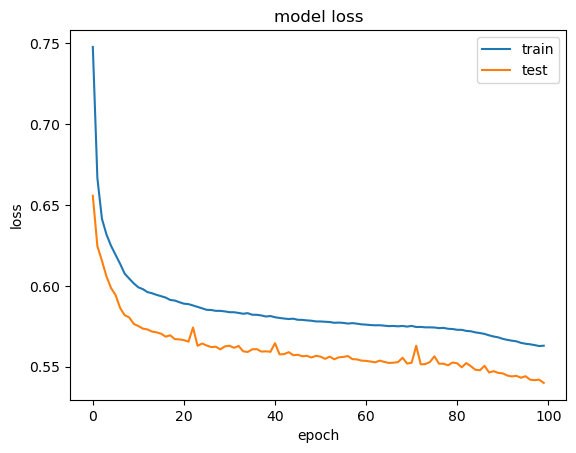

In [82]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

### Test

In [83]:
autoencoder = load_model('fraudAE.pth')

In [84]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

2671/2671 [==============================] - 5s 2ms/step


,reconstruction_error,true_class
count,85443.000000,85443.00000
mean,0.591498,0.00165
std,3.535218,0.04059
min,0.025158,0.00000
25%,0.158777,0.00000
50%,0.260181,0.00000
75%,0.464470,0.00000
max,413.930868,1.00000


In [85]:
threshold = 2.9

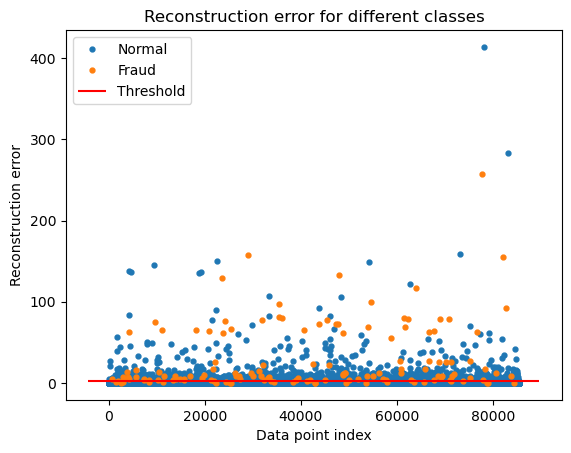

In [86]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

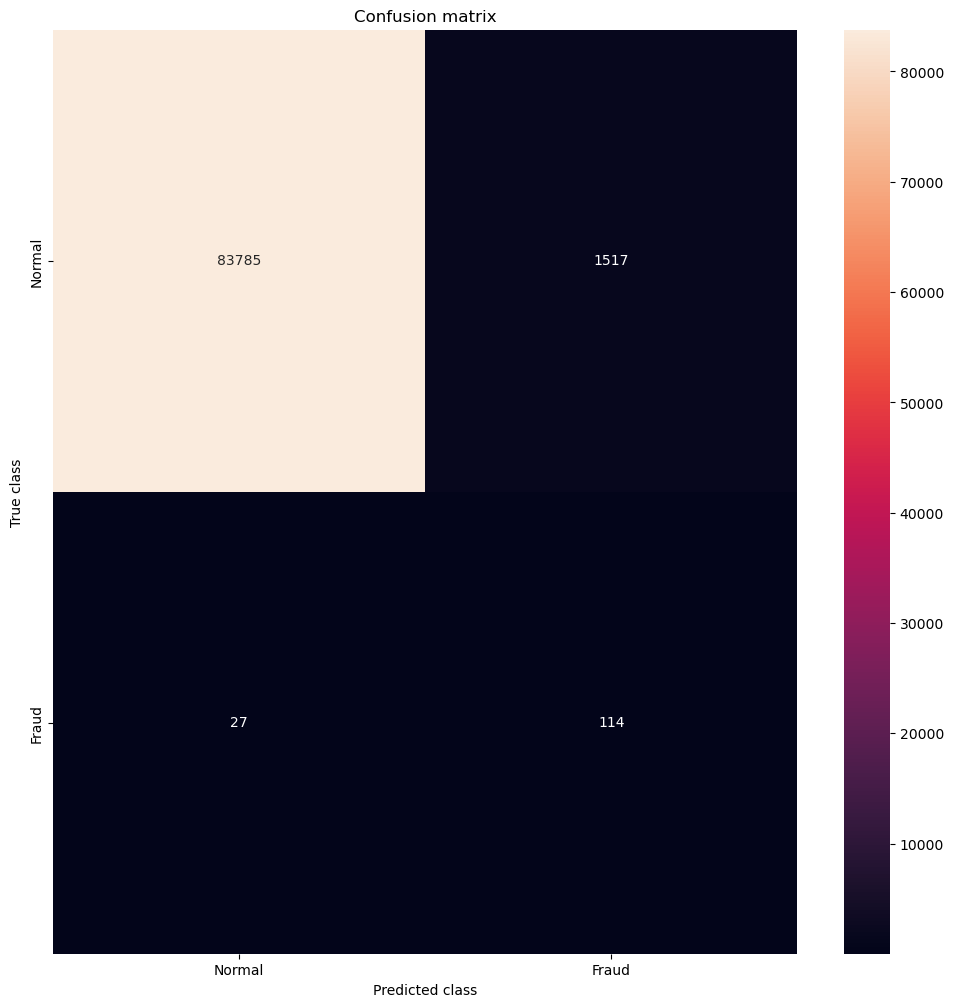

In [87]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
LABELS = ['Normal','Fraud']

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### Visualize the latent space

In [88]:
inp_layer = autoencoder.input
out_layer = autoencoder.layers[3].output

encoder = Model(inputs=inp_layer, outputs=out_layer)

In [89]:
encoder.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28)]              0         
                                                                 
 dense_16 (Dense)            (None, 14)                406       
                                                                 
 dense_17 (Dense)            (None, 7)                 105       
                                                                 
 dense_18 (Dense)            (None, 3)                 24        
                                                                 
Total params: 535 (2.09 KB)
Trainable params: 535 (2.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [90]:
fraud = X_test[y_test==1]
normal = X_test[y_test==0]

features = np.append(fraud, normal, axis=0)
labels = np.append(np.ones(len(fraud)), np.zeros(len(normal)))

latent_vector = encoder.predict(features)

2671/2671 [==============================] - 6s 2ms/step


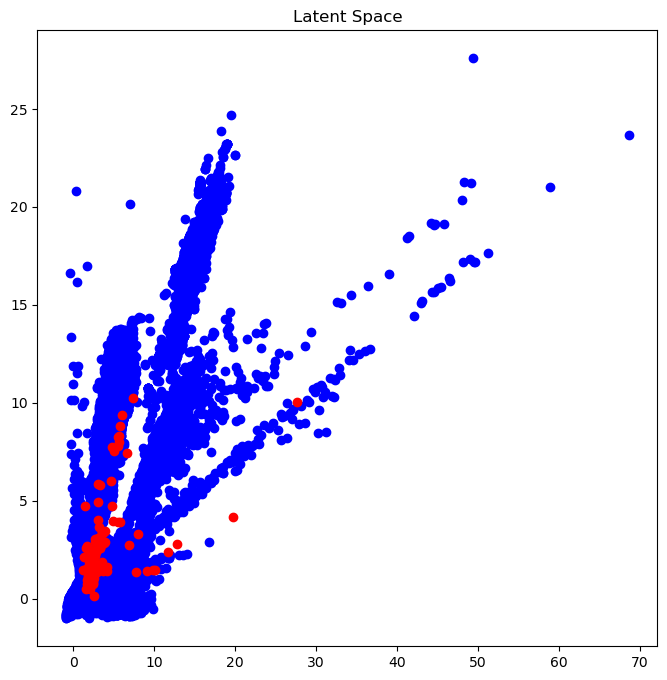

In [91]:
X = latent_vector[:,0]
y = latent_vector[:,1]

plt.subplots(figsize=(8, 8))
plt.scatter(X[labels==0], y[labels==0], color="blue", label='Normal')
plt.scatter(X[labels==1], y[labels==1], color="red", label='Fraud')

plt.title('Latent Space')
plt.show()